In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from torchvision import models

In [2]:

transform = transforms.Compose(
    [
        transforms.CenterCrop((500, 500)),
        transforms.Resize(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
     ])
train_dataset = datasets.Flowers102('data', split = 'train', download=True, transform=transform)
validation_dataset = datasets.Flowers102('data', split = 'val', download=True, transform=transform)
test_dataset = datasets.Flowers102('data', split = 'test', download=True, transform=transform)


In [3]:
phases = {
    'train': train_dataset,
    'valid': validation_dataset,
    'test': test_dataset
    }
loader = {
    phase: DataLoader(ds, batch_size=4, shuffle=(phase=='train'))
    for phase, ds in phases.items()
}

In [4]:
train_dataset[0][0].shape

torch.Size([3, 299, 299])

In [5]:
def visualize(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(str(label))
  plt.xticks([])
  plt.yticks([])


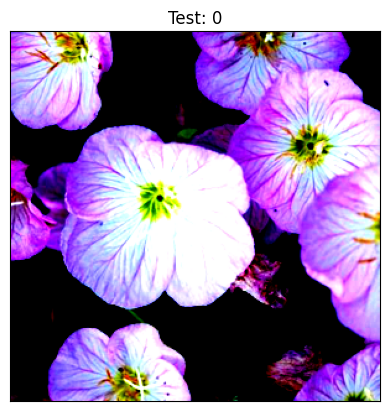

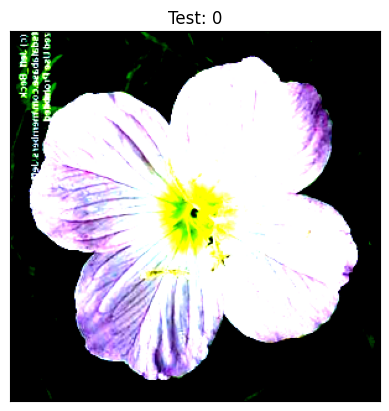

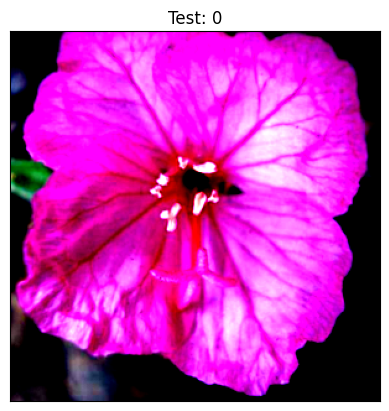

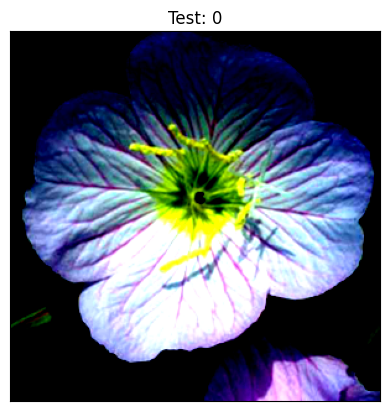

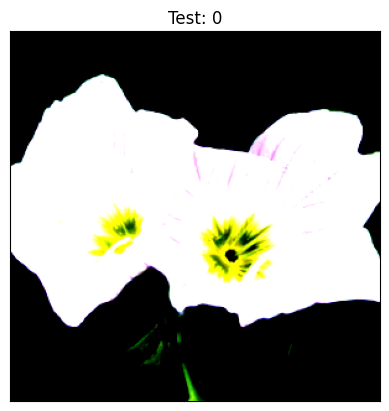

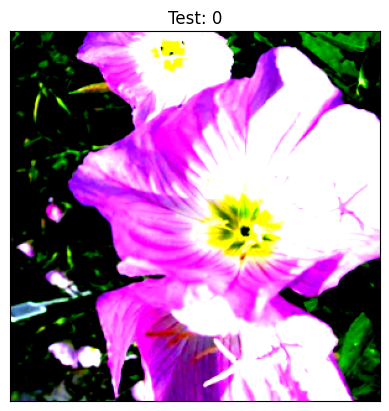

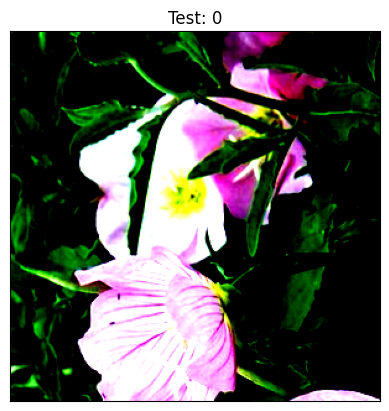

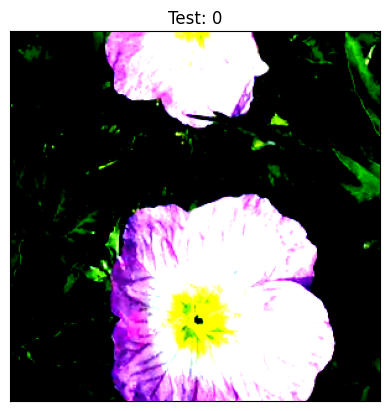

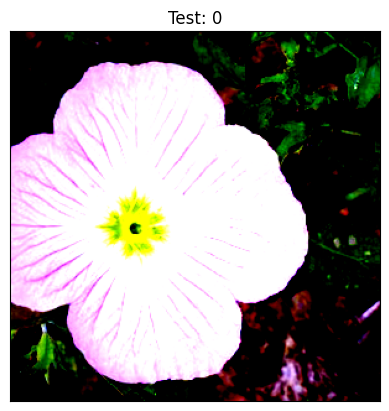

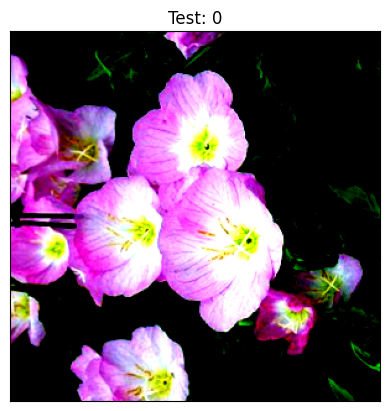

In [6]:
train_examples = [train_dataset[i] for i in range(10)]
for image, label in train_examples:
  image = torch.permute(image, (2, 1, 0)).numpy()
  visualize(image, f'Test: {label}')


## Transfer Learning
Transfer learning is a machine learning technique where a pre-trained model, typically developed for one task, is reused as the starting point for a different but related task. The concept is based on the observation that knowledge gained while solving one problem can be applied to a different but related problem. For instance, a model trained on a large-scale image recognition task could be used as the basis for a system designed to recognize different flower images. This approach can significantly reduce computational cost and training time, especially in limited data scenarios. Here we used the model initially trained on the ImageNet dataset for our task.

Note: The original ImageNet dataset, known as ImageNet 2012, consists of over 1.2 million training images and 50,000 validation images across 1,000 object categories. These images were collected from the web and hand-annotated by human labelers. The dataset was expanded over the years, with subsequent versions like ImageNet 2014 and ImageNet 2017 including more images and additional annotations.

In [7]:
model = models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Freezing some of the model parameters
This technique is commonly used in transfer learning scenarios, where a pre-trained model is used as a starting point for a new task. By freezing the initial layers of the model, which capture general low-level features, the learned representations are preserved, while allowing the subsequent layers to adapt to the specific task at hand. Freezing weights helps in preventing the loss of valuable knowledge encoded in the pre-trained layers, especially when the new task has limited training data.

In [8]:
# for parameter in model.parameters():
#     parameter.requires_grad = False

The classifier layer of the Inception network is typically designed to predict the classes of the ImageNet dataset, which consists of 1,000 object categories. However, for the Flower102 dataset, which contains 102 specific flower categories, the classifier layer needs to be adapted to accurately classify the flowers. Also, it is frozen; when replacing it with a new classifier, the parameters of the new classifier are not frozen and can be learned during the training process.

In [9]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.Linear(256, 102)
)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [11]:
def evaluate(model, loader, device, criterion, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  total = 0
  for i, (images, labels) in enumerate(loader[mode]):
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')




In [14]:
model = model.to(device)
epochs = 100
for epoch in range(epochs):
  model.train()
  total = 0
  total_correct = 0
  total_loss = 0
  for i, (images, labels) in enumerate(loader['train']):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs, _ = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total += images.size(0)
    _, predictions = outputs.max(1)
    total_correct += (predictions == labels).sum()
    total_loss += loss.item() * images.size(0)
  accuracy = total_correct / total
  loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')
  evaluate(model, loader, device, criterion, mode='valid')

Train epoch 0: Loss(2.3712) Accuracy (0.3069)
valid epoch 0: Loss(6.1372) Accuracy (0.1020)
Train epoch 1: Loss(2.3699) Accuracy (0.3294)
valid epoch 1: Loss(3.5465) Accuracy (0.2765)
Train epoch 2: Loss(2.1556) Accuracy (0.3667)
valid epoch 2: Loss(3.1484) Accuracy (0.3500)
Train epoch 3: Loss(1.8651) Accuracy (0.4382)
valid epoch 3: Loss(3.1313) Accuracy (0.3412)
Train epoch 4: Loss(1.6666) Accuracy (0.5020)
valid epoch 4: Loss(2.6037) Accuracy (0.3814)
Train epoch 5: Loss(1.6082) Accuracy (0.4912)
valid epoch 5: Loss(2.9107) Accuracy (0.4000)
Train epoch 6: Loss(1.4179) Accuracy (0.5598)
valid epoch 6: Loss(3.0391) Accuracy (0.3971)
Train epoch 7: Loss(1.2984) Accuracy (0.6078)
valid epoch 7: Loss(2.6182) Accuracy (0.4735)
Train epoch 8: Loss(1.1077) Accuracy (0.6618)
valid epoch 8: Loss(3.0254) Accuracy (0.4725)
Train epoch 9: Loss(0.9471) Accuracy (0.6843)
valid epoch 9: Loss(3.1471) Accuracy (0.4284)
Train epoch 10: Loss(0.9938) Accuracy (0.6941)
valid epoch 10: Loss(2.8558) Accu

In [15]:
evaluate(model, loader, device, criterion, mode='test')


test epoch 99: Loss(3.7991) Accuracy (0.5269)


#How do you address model overfitting?
- Data augmentation (see the Image IO and Image Augmentation notebook on D2L)
- Using different models
- [Ensemble Learning](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/)
- Hyperparameters Optimization and model fine-tuning
- ...